# D603 - Machine Learning #  
**Performance Assessment 3 - Time Series Modeling**

Bernard Connelly  
Master of Science, Data Analytics, Western Governor's University  
Dr. Sherin Aly  
March 31, 2025

### Part 1: Research Question & Preparation ###

**B1. Research Question**  
How accurately can an ARIMA model forecast daily hospital revenue for 180 days out-of-sample based solely on historical revenue patterns?

**B2. Objective of Analysis**  
This analysis aims to provide the hospital with actionable insight into its expected revenue over the next six months. Using an ARIMA model, the analysis will account for trends, seasonality, and noise in the historical data while generating a forecast based solely on previous revenue patterns. This will allow hospital administrators to assess the financial viability of their current business model and determine whether any significant policy changes are necessary to maintain or improve revenue.

**C. Assumptions of Time Series Modeling**  
One key assumption of an ARIMA model is that the time series data is stationary, meaning it has a constant mean and variance over time and lacks strong trends or seasonal patterns. Stationarity ensures that the model can effectively learn from past patterns and generalize them to future periods. Techniques such as differencing, log transformation, or square root transformation may be applied to achieve stationarity. Additionally, the Augmented Dickey-Fuller (ADF) test will be used to statistically assess whether the series is stationary.

Another important assumption is autocorrelation - the statistical relationship between a value in the time series and its previous values. In raw time series data, autocorrelation is expected and can be informative, particularly for setting the autoregressive(AR) and moving average (MA) components of the ARIMA model. However, after the model has been fitted, the residuals should not exhibit significant autocorrelation. This ensures the model has effectively captured the underlying patterns and that the remaining error behaves like random noise.


In [4]:
# Importing Necessary Packages
import numpy as np ## To use statistical methods and values
import pandas as pd ## General Dataframe and functionality
from IPython.display import display ## For cleaner printing of data
import matplotlib.pyplot as plt ## Visualizations
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Partial + Full Autocorrelation Plots
from statsmodels.tsa.seasonal import seasonal_decompose # Time series decomposition
from scipy.signal import periodogram # Spectral Density
from statsmodels.tsa.arima.model import ARIMA # ARIMA Model
import warnings 
warnings.filterwarnings("ignore") # Suppressing warnings
from sklearn.metrics import mean_squared_error # Mean Squared Error

### Part 2: Data Pre-Processing ###

In [6]:
# Importing the dataset
file_location = "C:/Users/bconn/OneDrive/Documents/WGUCoursework/Data/medical_clean.csv"

data = pd.read_csv(file_location)
df = data.copy()

# Basic Profiling
display(df.head())
display(df.describe())
display(df.dtypes.to_frame('Data Types'))

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


,Day,Revenue
count,731.000000,731.000000
mean,366.000000,14.179608
std,211.165812,6.959905
min,1.000000,-4.423299
25%,183.500000,11.121742
50%,366.000000,15.951830
75%,548.500000,19.293506
max,731.000000,24.792249


,Data Types
Day,int64
Revenue,float64


**D1. Line Graph of Time Series**  
The line graph was separated into 60-day intervals to estimate months and years at a glance.

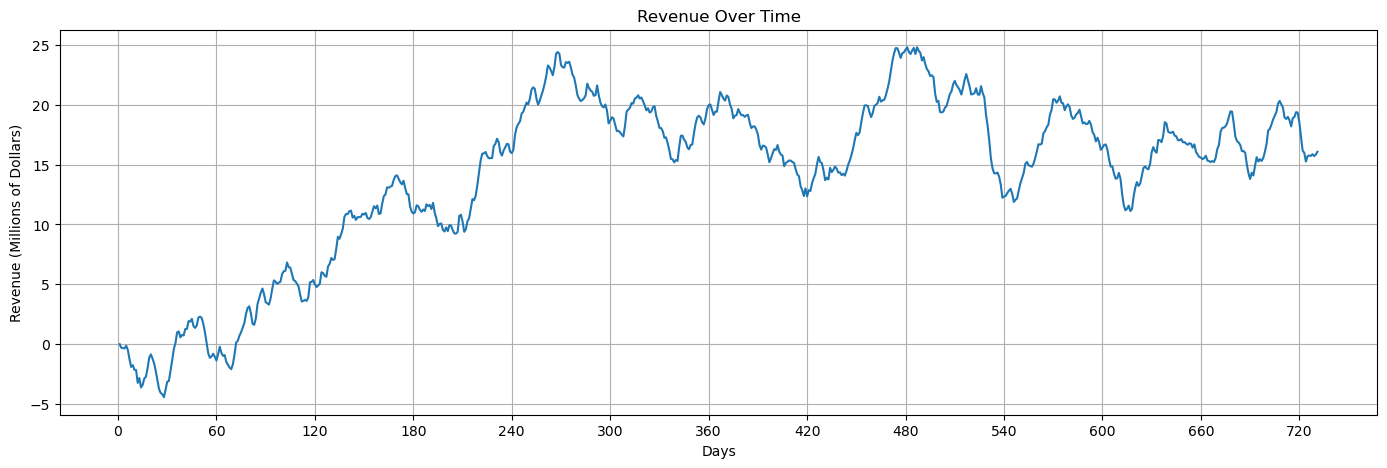

In [8]:
# Plotting Initial Line Graph
plt.figure(figsize = [17,5])
xtick_positions = list(range(0, 732, 60))
xtick_labels = [f'{i}' for i in xtick_positions]
revenue = df["Revenue"]
days = df["Day"]

plt.plot(days,revenue)
plt.title("Revenue Over Time")
plt.xlabel("Days")
plt.ylabel("Revenue (Millions of Dollars)")

plt.xticks(xtick_positions, xtick_labels)
plt.grid(True)
plt.show()

**D2. Time Step Formatting Process**  
The time step is measured in days, with a single observation recorded daily. There are a total of 731 evenly-spaced observations, which makes up approximately 2 years of data. The time series has no visible gaps, as each consecutive day is accounted for in the dataset. No duplicate entries were observed within the dataset.

**D3. Evaluation of Stationarity**  
The data is not currently stationary. The initial 260 or so days demonstrate an accelerating trend and mean overall before it changes to decelerate through around day 420 and remains variable afterward. Additionally, there are possible indications of seasonality, with peaks and valleys occurring at regular intervals every 50-80 days. As this violates one of the assumptions of an ARIMA model, these problems must be resolved before implementing the model. The next step is to run an Augmented Dickey-Fuller test to identify p-values and test the null hypothesis that the data is not stationary.

In [11]:
# Running Augmented Dickey-Fuller Test
adf_result = adfuller(df['Revenue'])
print('ADF Statistic: ', adf_result[0])
print('p-value: ', adf_result[1])
print('# of lags: ', adf_result[2])
print('# of observations: ', adf_result[3])
print('Critical Values: ', adf_result[4])
print('AIC: ', adf_result[5])

ADF Statistic:  -2.2183190476089485
p-value:  0.19966400615064228
# of lags:  1
# of observations:  729
Critical Values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
AIC:  842.453027617641


The ADF statistic of -2.22 is not more negative than any of the critical values, meaning there is insufficient evidence to reject the null hypothesis that the data is non-stationary. Additionally, the p-value of 0.2 is well above the standard 0.05 threshold expected to reject the null hypothesis. As a result, additional steps need to be taken to difference the data and create stationarity before an ARIMA model can be fit and run

**D4. Data Preparation and Splitting**  
According to the metrics from the ADF test, The data is currently not stationary, so first-order differencing will be applied to the dataset. The code below creates a new column that differences the revenue data, then runs the Augmented Dickey-Fuller Test again on the dataset to identify if the data is stationary.

In [14]:
# Differencing the dataset and retesting
df['Revenue_diff1'] = df['Revenue'].diff()
adf_result = adfuller(df['Revenue_diff1'].dropna())
print('ADF Statistic: ', adf_result[0])
print('p-value: ', adf_result[1])
print('# of lags: ', adf_result[2])
print('# of observations: ', adf_result[3])
print('Critical Values: ', adf_result[4])
print('AIC: ', adf_result[5])

ADF Statistic:  -17.374772303557062
p-value:  5.113206978840171e-30
# of lags:  0
# of observations:  729
Critical Values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
AIC:  846.2604386450553


The results of the 2nd ADF test indicate a p-value that is 5.11e-30, well below the 0.05 threshold. Additionally, the ADF Statistic is -17.4, a negative value far lower than all three critical value thresholds. These metrics provide strong evidence to reject the null hypothesis, meaning the data is now stationary. With the major assumptions of the ARIMA model met, the next steps in the process are to split the data into training and test datasets.

In [16]:
# Splitting the dataset 80-20
revenue_diff = df['Revenue_diff1'].dropna()
split = int(len(revenue_diff) * 0.8)

train = revenue_diff[:split]
test = revenue_diff[split:]

print('Train Set Count: ', len(train))
print('Test Set Count: ', len(test))

Train Set Count:  584
Test Set Count:  146


**D5. Export the Cleaned Dataset**  
The first row of `Revenue_diff1` contains `NaN` values due to the differencing process. 

In [18]:
# Exporting the Dataset
df_cleaned = df[['Day', 'Revenue', 'Revenue_diff1']]
df_cleaned.to_csv('cleaned_revenue_dataset.csv', index=False)

### Part 3: Analysis of the Time Series Dataset & Model Optimization ###

**E1. Annotated Findings and Visualizations**  
Each of the required metrics for the project will be handled individually to ensure clarity in visualizations. The first detail required is the trends. To illustrate progress so far, the original revenue chart will be placed above the new differenced revenue chart for easy comparison.

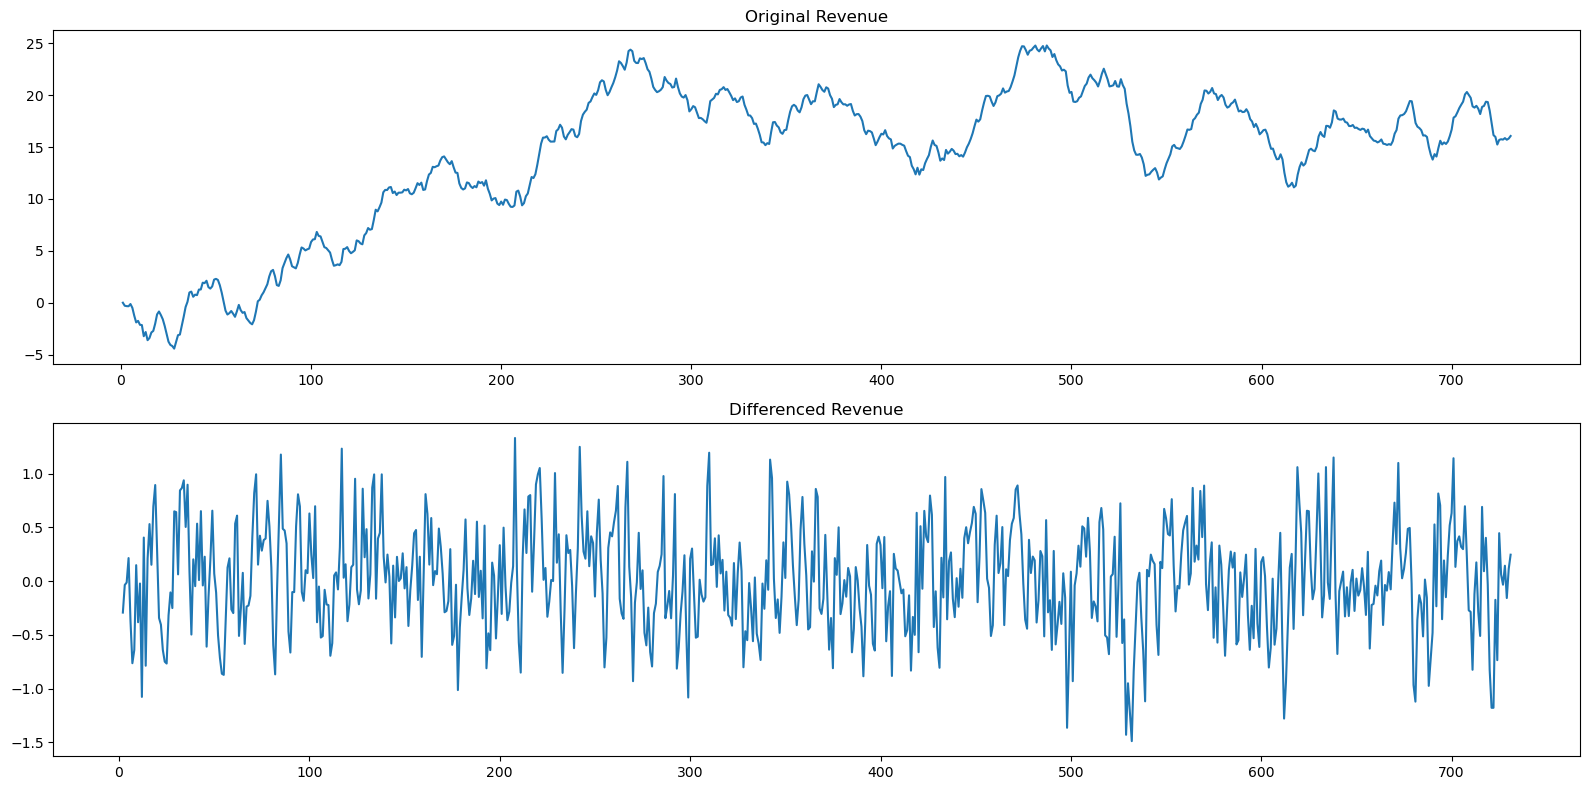

In [20]:
# Charting Revenue + Stationary Revenue
plt.figure(figsize=(16 ,8))
plt.subplot(2, 1, 1)
plt.title("Original Revenue")
plt.plot(df['Day'], df['Revenue'])

plt.subplot(2, 1, 2)
plt.title("Differenced Revenue")
plt.plot(df['Day'], df['Revenue_diff1'])

plt.tight_layout()
plt.show()

The top graph demonstrates the original data, showing clear trends over time. The bottom plot shows the differenced revenue series and demonstrates rapid oscillation of the values around a constant mean with no clear trend. The next step is to plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to visualize various lags in the time series. These will be plotted next to one another for a quick comparison. I will check around 10% of the dataset length, which is a standard value that should provide clear visuals for how many lags may be optimal in the ARIMA Model.

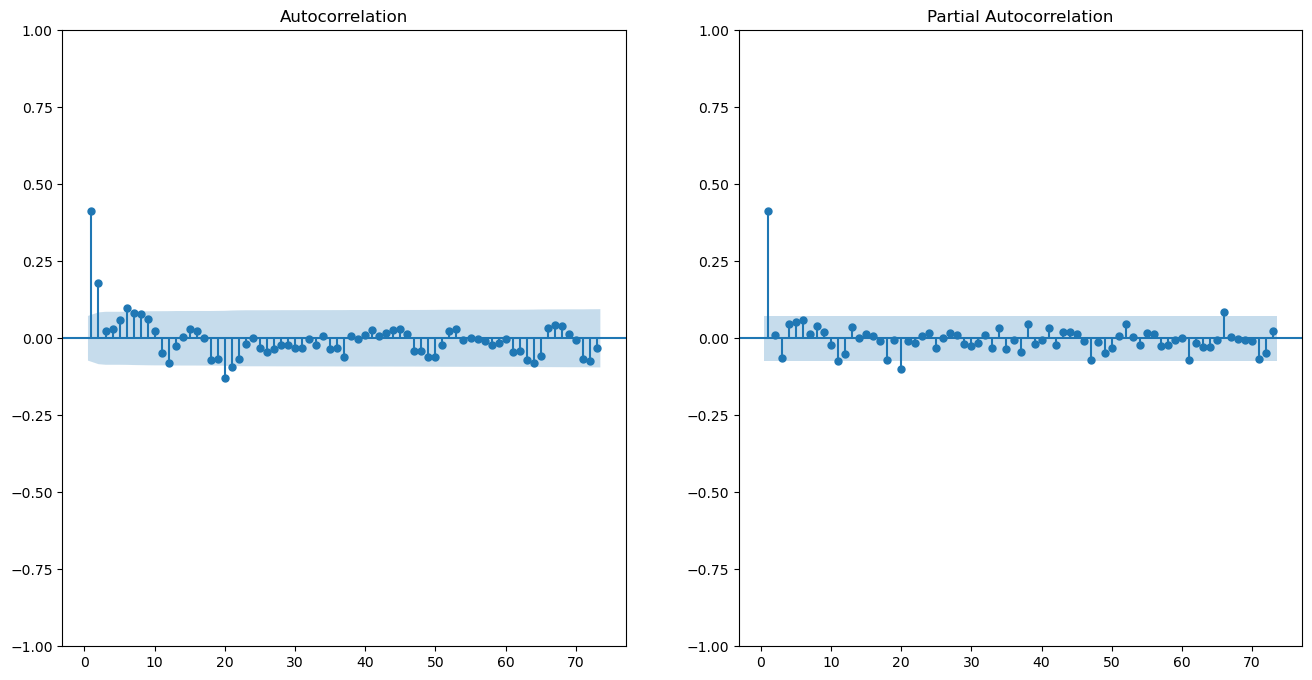

In [22]:
# Plotting ACF & PACF
lags = int(len(df) / 10) 

plt.figure(figsize=(16 , 8))
plt.subplot(1, 2, 1)
plot_acf(df['Revenue_diff1'].dropna(), lags = lags, zero = False, ax=plt.gca())
plt.subplot(1, 2, 2)
plot_pacf(df['Revenue_diff1'].dropna(), lags = lags, zero = False, ax=plt.gca())
plt.show()

Based on the ACF and PACF plots above, the strongest statistically significant autocorrelations occur at lag 1 for both plots. The PACF shows a substantial dropoff from about .4 to .2 between the 1st and 2nd lags, and all remaining lags, besides some outliers, are statistically insignificant. This suggests an autoregressive term of p=1. The ACF also shows a single spike followed by an immediate fall, indicating a moving average term of q=1.

The next step is to identify the time series's Spectral Density, which will determine how much variance is explained by different frequencies.

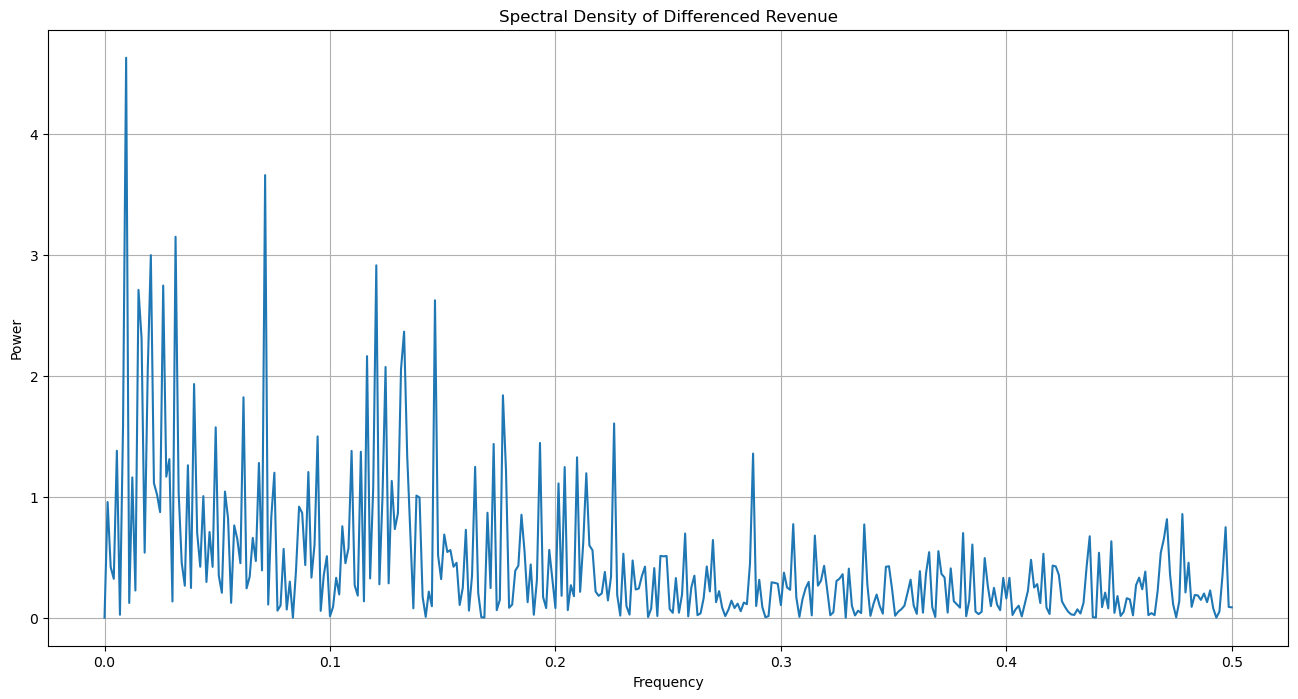

In [24]:
# Spectral Density Plot
revenue_diff = df['Revenue_diff1'].dropna()
f, p = periodogram(revenue_diff) ## Spectral Density calculation

plt.figure(figsize=(16, 8))
plt.title("Spectral Density of Differenced Revenue")
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)
plt.plot(f, p)
plt.show()

The Spectral Density graph above supports the earlier findings of the ACF and PACF of the differenced dataset. The highest values for power are concentrated at low frequencies, indicating the primary source of variance in the differenced data comes from slower, long-term changes. Further, there are no strong peaks at higher frequencies, suggesting the time series lacks short-term periodicity or seasonality and that using a non-seasonal ARIMA model is viable in this scenario. 

With Spectral Density complete, the next step is to move on to the time series decomposition. Since the values of our dataset oscillate around zero after differencing, I will use the additive model. I also assume seasonality occurs every month, so will use a 30 day period to closely estimate each month.

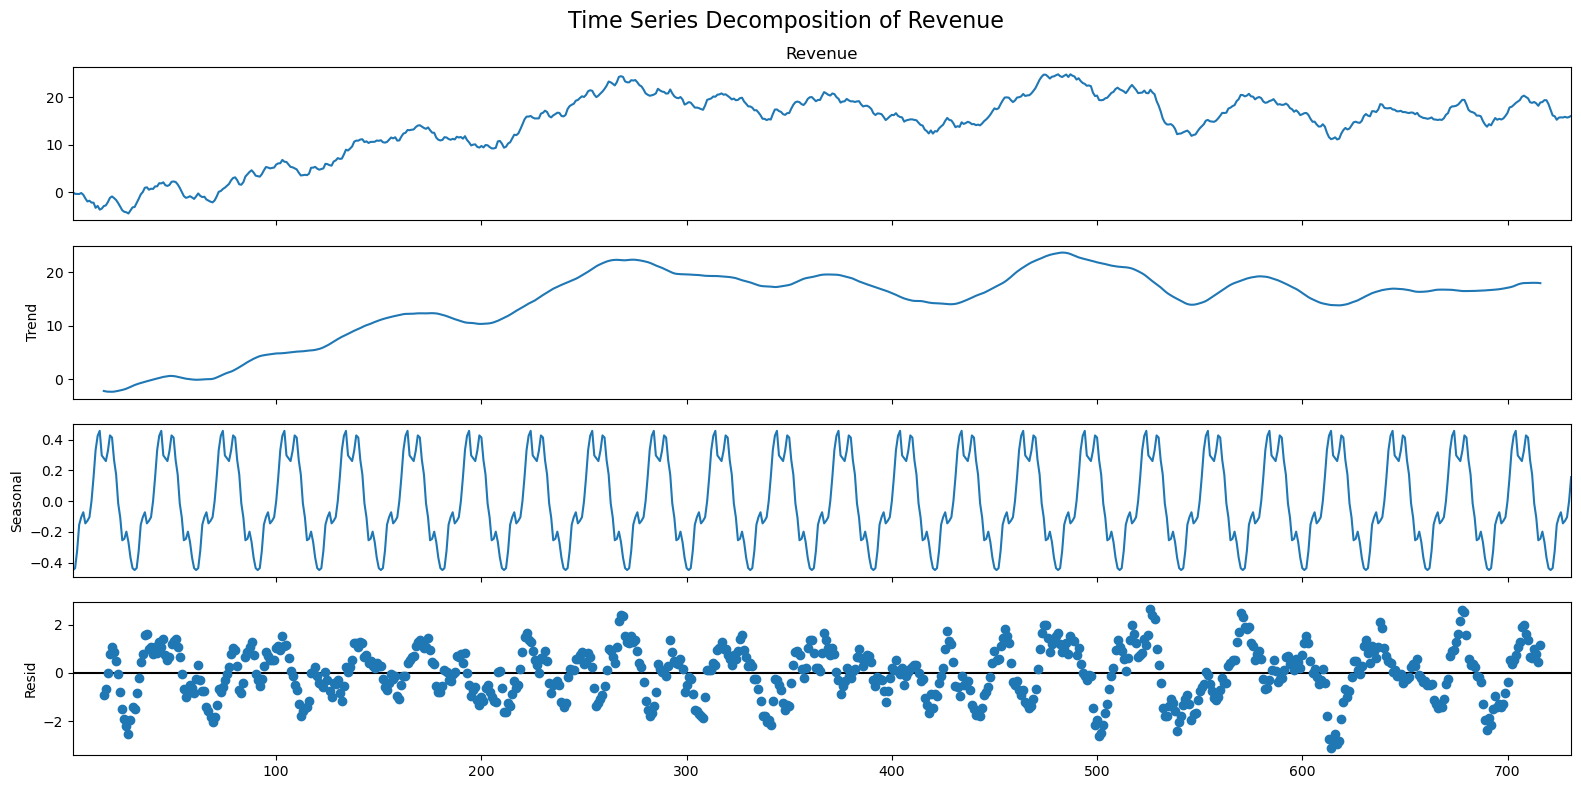

In [26]:
# Time Series Decomposition
df_decomp = df.copy()
df_decomp.set_index('Day', inplace=True)
result = seasonal_decompose(df_decomp['Revenue'], model='additive', period=30)

result.plot()
plt.gcf().set_size_inches(16,8)
plt.suptitle("Time Series Decomposition of Revenue", fontsize=16)
plt.tight_layout()
plt.show()

The decomposition data looks appropriate -  the trend and charted values can be seen clearly against the seasonal and residual values. Further review demonstrates continued peaks and valleys at a fairly consistent basis in the residual data, and 24 peaks are demonstrated in the residual graph - consistent with a monthly trend over the course of two years. As a result, I will conduct an additional test to confirm there is not a leftover seasonal pattern the decomposition did not fully capture. This will be completed by plotting the ACF of the residuals.

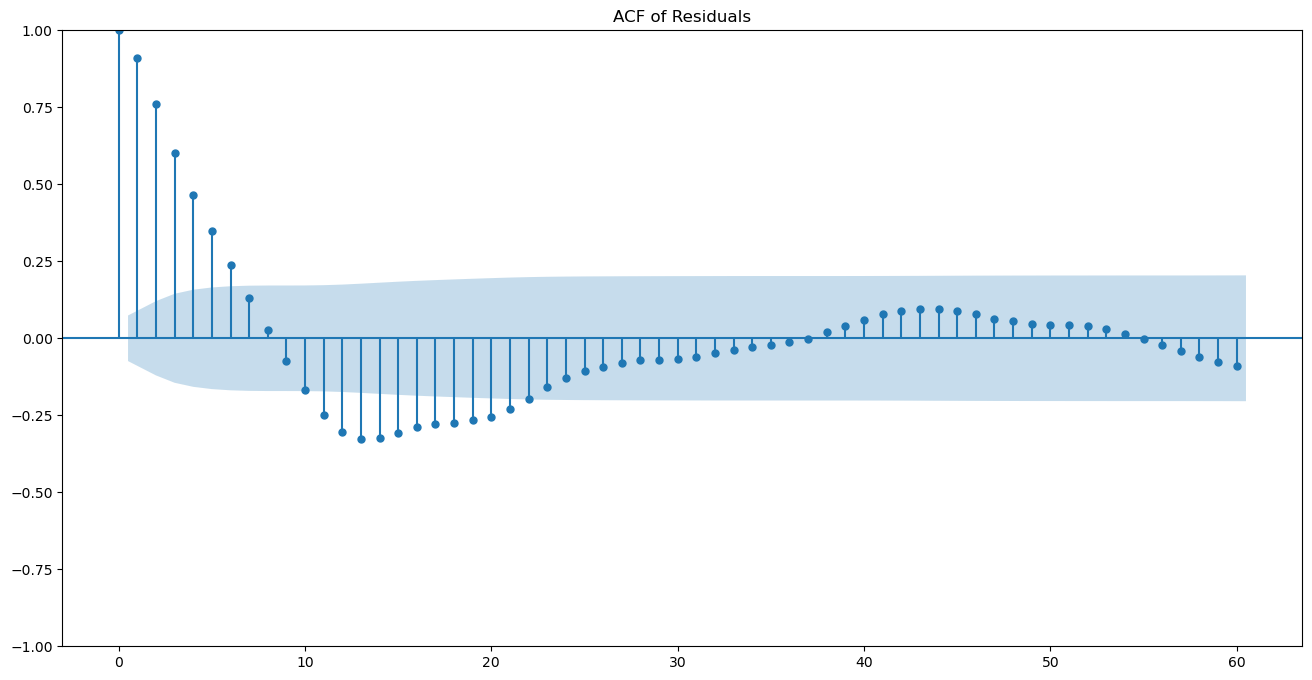

In [28]:
# Plotting ACF of Residual Values from Decomposition
plot_acf(result.resid.dropna(), lags=60)
plt.gcf().set_size_inches(16,8)
plt.title("ACF of Residuals")
plt.show()

Per the above test, the ACF plot shows autocorrelation and a wave-like structure beyond lag 30, suggesting the original dataset had hidden seasonality. Before taking further action to confirm if this seasonality needs to be removed, I will decompose the differenced data to identify if the seasonality was successfully removed.

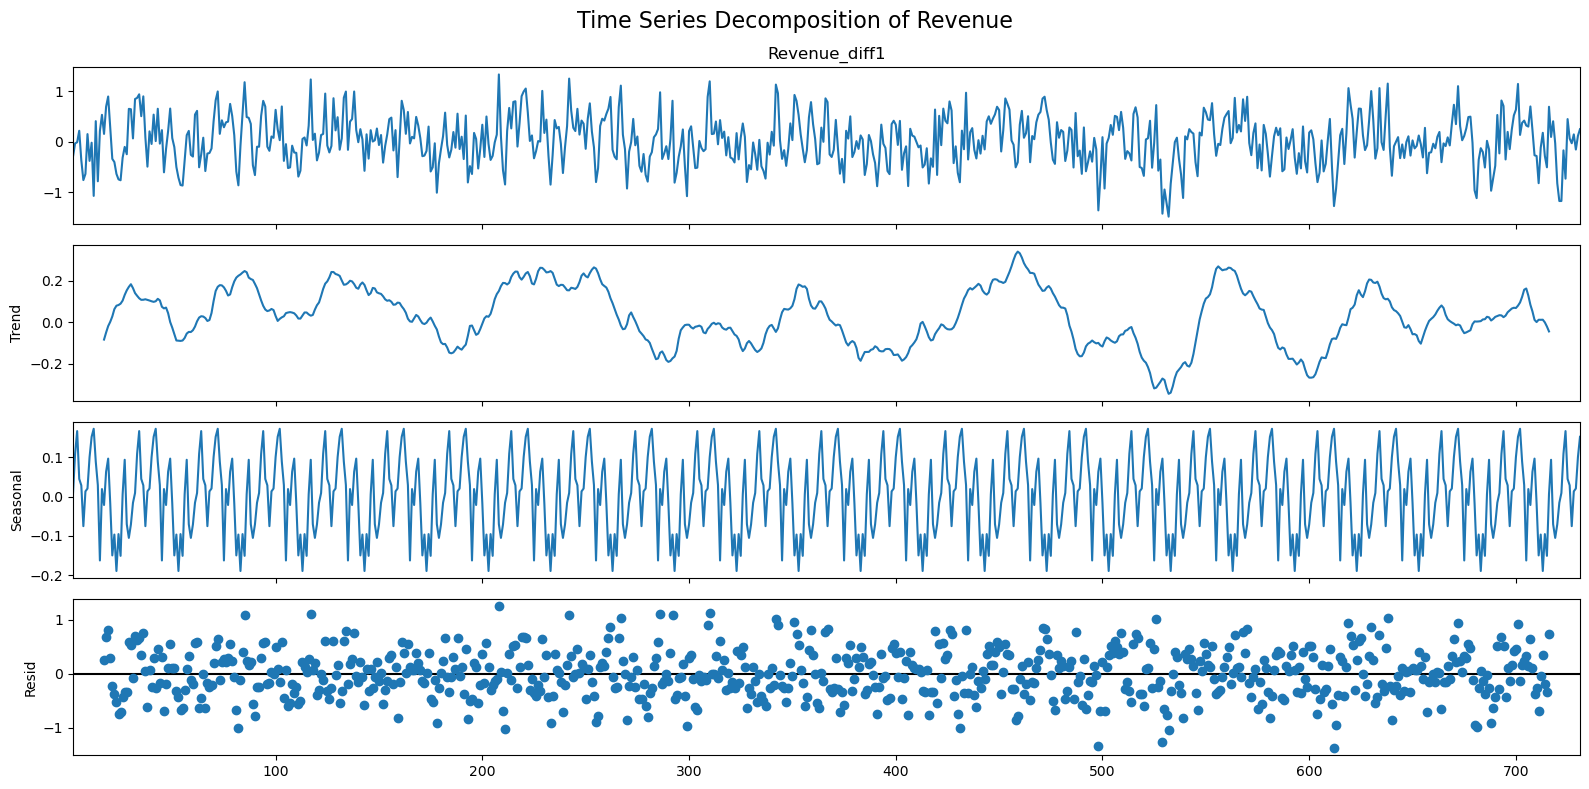

In [30]:
# Time Series Decomposition of Differenced Data
df_differenced_decomp = df.copy()
df_differenced_decomp.set_index('Day', inplace=True)
result = seasonal_decompose(df_decomp['Revenue_diff1'].dropna(), model='additive', period=30)

result.plot()
plt.gcf().set_size_inches(16,8)
plt.suptitle("Time Series Decomposition of Revenue", fontsize=16)
plt.tight_layout()
plt.show()

Per the above decomposition of the Revenue_diff1 series, the trend component was nearly flat and centered around 0, and the residuals closely resembled white noise, indicating the absence of autocorrelation and seasonality. This confirms that the data is now properly stationary and suitable for ARIMA modeling.

**E2. ARIMA Model Identification**  
From the previous steps and analysis performed, I have already identified a starting point for the ARIMA model as:
 p = 1 (PACF drops sharply after lag 1)
 d = 1 (Differencing at 1 lag removed seasonality in residuals & trend)
 q = 1 ((ACF shows one clear spike and drops off)

 As such, I will start my initial model with the (1,1,1) values before inspecting other options.

In [33]:
# Fitting the 1-1-1 ARIMA Model
model = ARIMA(df['Revenue'], order=(1,1,1))
arima111_results = model.fit()
print(arima111_results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -437.964
Date:                Sat, 05 Apr 2025   AIC                            881.927
Time:                        08:47:59   BIC                            895.706
Sample:                             0   HQIC                           887.243
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4294      0.087      4.960      0.000       0.260       0.599
ma.L1         -0.0184      0.094     -0.196      0.845      -0.202       0.165
sigma2         0.1943      0.011     17.757      0.0

The (1,1,1) model demonstrates AIC and BIC values under 1000 and are within a reasonable range for analysis. The coefficient of ar.L1 is 0.43, which is statistically significant; The lag-1 autoregressive term improves the model. Additionally, the coefficient of sigma2 also indicates statistical significance for the estimated variance of residuals at 0.19. Also of note, the aforementioned model coefficients p-values are both at or near 0, indicating evidence against the null hypothesis, and that the model is statistically significant. Also of note, the Ljeung-Box Q is at 0, Prob(Q) is .98, indicating residuals are uncorrelated, and the Skew / Kurtosis values indicate a close to normal distribution. The one noted value that is awry is the p-value of ma.L1, which is 0.845, and the coefficient is -0.0184, indicating the MA portion of the ARIMA model is not contributing significantly. Several other ARIMA configurations will be tested to identify if there is a better fit available, including a 1, 1, 0 model, which will drop the MA portion that is insignificant and serves to add unnecessary complexity.

In [35]:
# Fitting the 1-1-0 ARIMA Model
model = ARIMA(df['Revenue'], order=(1,1,0))
arima110_results = model.fit()
print(arima110_results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -437.991
Date:                Sat, 05 Apr 2025   AIC                            879.982
Time:                        08:47:59   BIC                            889.168
Sample:                             0   HQIC                           883.526
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4142      0.034     12.258      0.000       0.348       0.480
sigma2         0.1943      0.011     17.842      0.000       0.173       0.216
Ljung-Box (L1) (Q):                   0.02   Jarque-

As noted, the (1,1,0) configuration highlights a better fit than the previous (1,1,1) model with slightly reduced AIC and BIC values, consistent values in the ar.L1 and sigma2 coefficients and p-values, and the other coefficients and values at or near what was identified in the (1,1,1) ARIMA model. This model is less complex and less likely to overfit the data, so for now this is the optimal configuration. Additional configurations will also be tested and the results will be compared to the (1,1,0) model.

In [37]:
# Fitting the 2-1-2 ARIMA Model
model = ARIMA(df['Revenue'], order=(2,1,2))
arima212_results = model.fit()
print(arima212_results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -435.983
Date:                Sat, 05 Apr 2025   AIC                            881.965
Time:                        08:47:59   BIC                            904.931
Sample:                             0   HQIC                           890.826
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1814      0.452      0.401      0.688      -0.705       1.068
ar.L2         -0.0432      0.226     -0.191      0.848      -0.485       0.399
ma.L1          0.2312      0.450      0.514      0.6

In [38]:
# Fitting the 1-2-0 ARIMA Model
model = ARIMA(df['Revenue'], order=(1,2,0))
arima120_results = model.fit()
print(arima120_results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -529.643
Date:                Sat, 05 Apr 2025   AIC                           1063.287
Time:                        08:47:59   BIC                           1072.470
Sample:                             0   HQIC                          1066.830
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2992      0.035     -8.438      0.000      -0.369      -0.230
sigma2         0.2503      0.015     16.974      0.000       0.221       0.279
Ljung-Box (L1) (Q):                   2.00   Jarque-

In [39]:
# Fitting the 2-1-1 ARIMA Model
model = ARIMA(df['Revenue'], order=(2,1,1))
arima211_results = model.fit()
print(arima211_results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -436.973
Date:                Sat, 05 Apr 2025   AIC                            881.947
Time:                        08:48:00   BIC                            900.319
Sample:                             0   HQIC                           889.035
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3267      0.318     -1.028      0.304      -0.950       0.296
ar.L2          0.3369      0.122      2.762      0.006       0.098       0.576
ma.L1          0.7279      0.325      2.243      0.0

In [40]:
# Fitting the 1-0-0 ARIMA Model
model = ARIMA(df['Revenue'], order=(1,0,0))
arima100_results = model.fit()
print(arima100_results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -509.965
Date:                Sat, 05 Apr 2025   AIC                           1025.930
Time:                        08:48:00   BIC                           1039.713
Sample:                             0   HQIC                          1031.247
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.6190      5.646      2.058      0.040       0.553      22.685
ar.L1          0.9983      0.002    469.563      0.000       0.994       1.003
sigma2         0.2345      0.013     18.592      0.0

In reviewing several other models, the (2,1,2) and (1,2,0) models both fell short in most evaluation metrics. These models exhibited generally higher AIC/BIC values, less optimal coefficient significance, and elevated p-values across various parameters - none of which justify the additional complexity to the current 1, 1, 0 frontrunner.

(2,1,1) outperforms the (1,1,0) in log likelihood, but introduces additional parameters, including one that is not statistically significant. Given the minimal improvement and increased complexity, this model is not enough of an improvement to justify use over the (1,1,0) model.

The ARIMA(1,0,0) model initially appears promising due to its significant coefficients. However, it incorrectly assumes stationarity and non-seasonality of the original revenue data, which was already disproven through the Augmented Dickey-Fuller test. As a result, this model is rejected, and the ARIMA(1,1,0) is still the best-fit model thus far.

The above tests confirm the (1,1,0) ARIMA model is the configuration that best accounts for the observed trend and seasonality of the time series data.

**E3 + E4. Perform a Forecast Using the Derived ARIMA model + Outputs & Calculations**  
The next steps are to fit the model to the full dataset, and confidence interval values. These details are coded and printed out below for reference and will be utilized in subsequent steps to plot the forecast as a part of the steps in part F of this project.

In [43]:
# Fitting the Model to full dataset and displaying results, including trend
model = ARIMA(df['Revenue'], order=(1, 1, 0), trend='t')
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -437.680
Date:                Sat, 05 Apr 2025   AIC                            881.359
Time:                        08:48:00   BIC                            895.139
Sample:                             0   HQIC                           886.675
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0219      0.028      0.789      0.430      -0.033       0.076
ar.L1          0.4130      0.034     12.218      0.000       0.347       0.479
sigma2         0.1942      0.011     17.851      0.0

In [44]:
# Forecast 180 days into the future
forecast_steps = 180
forecast = results.get_forecast(steps=forecast_steps)

In [45]:
# Identifying forecasted mean and confidence intervals
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

print("Confidence Intervals: \n", conf_int.head())
print("\nForecasted Mean: \n",forecast_mean.head())

Confidence Intervals: 
      lower Revenue  upper Revenue
731      15.320480      17.047774
732      14.749339      17.739390
733      14.255892      18.308327
734      13.831427      18.789704
735      13.461317      19.209053

Forecasted Mean: 
 731    16.184127
732    16.244364
733    16.282109
734    16.310566
735    16.335185
Name: predicted_mean, dtype: float64


In [46]:
# Future index
last_day = df['Day'].iloc[-1]
future_days = np.arange(last_day + 1, last_day + forecast_steps + 1)

### Part 4: Results & Recommendations ###
**F1. Results & Outcome of Analysis**  
As discussed in section E2, the ARIMA (1,1,0) model was selected due to its strong overall performance. It produced the lowest AIC/BIC values among the models tested, and its model coefficients were both statistically significant and interpretable. In particular, the autoregressive term (AR.L1) was highly significant, while residual diagnostics, including the Ljung-Box and heteroscedasticity tests, indicated white noise and an approximately normal distribution of errors.

For the forecast, the dataset was split into a standard 80% training and 20% testing configuration, resulting in 584 training observations and 146 test observations. This split ensures sufficient data for model learning while retaining enough unseen data for evaluating forecast accuracy. The forecast length of 146 days is justified by this split and is appropriate for a short- to medium-term projection.

A 95% prediction interval was generated alongside the point forecast to provide upper and lower bounds, capturing the expected variability in predictions. These intervals help assess the confidence level of the model’s output.

Finally, the model evaluation procedure involves comparing the forecasted revenue values to the actual values in the test set. The Root Mean Squared Error (RMSE) will be used as the primary error metric to quantify the average distance between predicted and observed values, helping to evaluate the effectiveness of the ARIMA(1,1,0) model. This is completed below using the training and test datasets.

**F2. Visualization of the Forecast & Final Model**  

In [49]:
# Calculating RMSE - Retraining training set and predicting test set before calculation
model_eval = ARIMA(train, order=(1, 1, 0))
results_eval = model_eval.fit()
forecast_eval = results_eval.get_prediction(start=test.index[0], end=test.index[-1])
forecasted_test = forecast_eval.predicted_mean

rmse = np.sqrt(mean_squared_error(test, forecasted_test))
print("RMSE on test set: ", rmse)

RMSE on test set:  0.5195698917750381


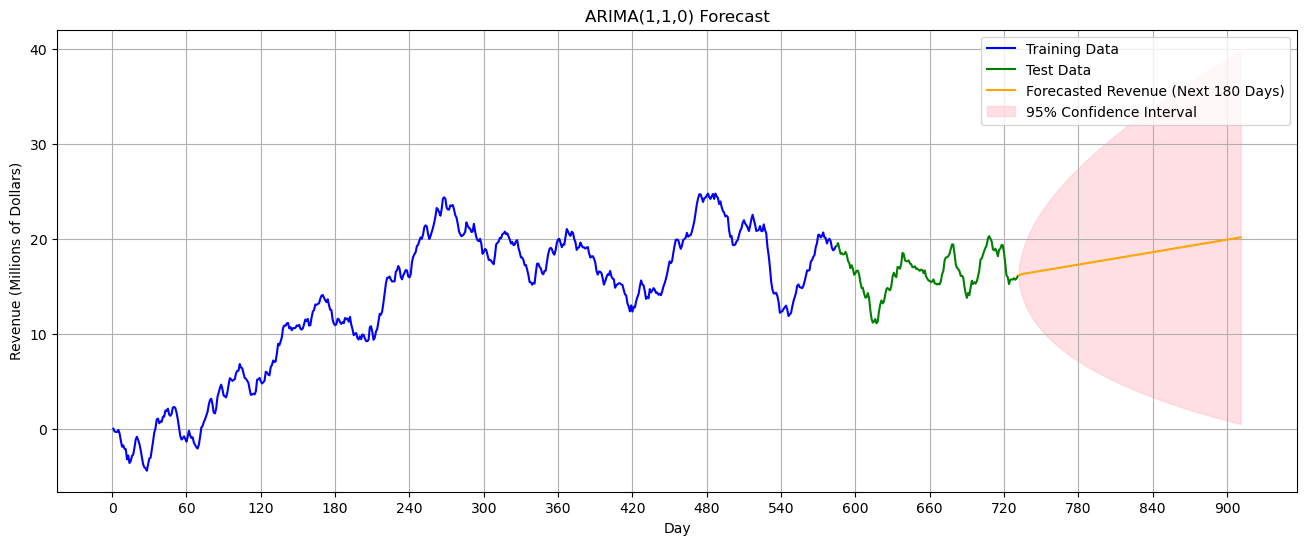

In [50]:
# Plotting the Revenue, Forecast, and Confidence Interval for the out of sample forecast

plt.figure(figsize=(16,6))
plt.plot(df['Day'][:split], df['Revenue'][:split], label='Training Data', color='blue')
plt.plot(df['Day'][split:], df['Revenue'][split:], label='Test Data', color='green')

plt.plot(future_days, forecast_mean, label='Forecasted Revenue (Next 180 Days)', color='orange')
plt.fill_between(future_days,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.5, label='95% Confidence Interval')

plt.title("ARIMA(1,1,0) Forecast")
xtick_positions = list(range(0, 932, 60))
xtick_labels = [f'{i}' for i in xtick_positions]
plt.xlabel("Day")
plt.ylabel("Revenue (Millions of Dollars)")
plt.xticks(ticks=xtick_positions, labels=xtick_labels)
plt.legend()
plt.grid(True)
plt.show()

**F3. Recommended Course of Action**  
The forecasted (1,1,0) ARIMA model predicted a slightly accelerating prediction line that aligns with observed historical patterns. This is moderate growth, consistent with prior trends.

RMSE was used as the error metric to evaluate the model's accuracy. The model’s RMSE on the test set was approximately 0.52 million, meaning the model’s daily revenue predictions were, on average, off by 520,000 dollars daily. Given that average daily revenue typically falls within the $10–20 million range, this represents a relative error of approximately 2–5%. While not extreme, this margin of error can compound significantly over longer forecasting horizons.

While the model demonstrates a reasonable expectation for future values, it does not account for the seasonality present in the original dataset. Additionally, the model includes a trend coefficient that was not statistically significant (p=.43). This trend improved the interpretability of the forecast and resulted in a slightly upward drift similar to the original revenue data. Given the visually reasonable output, this was retained to support directional guidance, however, the model output would be much flatter without including this term.

As a result of the above, it is recommended that the hospital revisit this analysis using a SARIMA model, which includes seasonal terms to account for recurring monthly or quarterly patterns. This would allow for a more responsive and reliable forecast aligned with the observed revenue cycles in the original data.

**H. Acknowledgement of Code Sources**  
Datacamp: ARIMA Models in Python by James Fultion was used for various ARIMA code steps, including Forecasts, differencing, fitting ARIMA models, spectral density, and testing for seasonality.

**I. Acknowledgement of Sources**  
whyamit404. (2025, February 9). Understanding numpy.cumsum() with examples. Medium. https://medium.com/@whyamit404/understanding-numpy-cumsum-with-examples-0394dc58ce79